In [1]:
##### Importing Libraries ######
#########################################

import pandas as pd
import numpy as np
import os
import seaborn as sns
import pickle ### helps storing data in pickle files

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix,f1_score ## model evaluation metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler ## (x-mean(variable))/standard_deviation(variable)
from sklearn.model_selection import StratifiedShuffleSplit ### datasplitting
 
from sklearn.model_selection import GridSearchCV          ### hyperparameter finding

from sklearn.tree import DecisionTreeClassifier           ### helps fitting a decision tree
from sklearn.ensemble import RandomForestClassifier       ### models from sklearn

In [2]:
%matplotlib inline

In [3]:
def capping(series,quantile_val):
  cap_value = series.quantile(quantile_val)
  series[series>cap_value] = cap_value
  return(series, cap_value)

def get_percentages(col_1, col_2, data):
  x = pd.crosstab(data[col_1],data[col_2])
  return(x[1]/(x[1]+x[2]))

In [4]:
####### Loading Data ######

cwd = os.getcwd() ##gets current working directory

data_path = str(cwd) + '/Existing_Base.csv'

data = pd.read_csv(data_path)  ## Loads the data

# Data Exploration

In [5]:
data.shape ## gets the shape of the data

(10155, 32)

In [6]:
#### Distribution of target class ####

data['Revenue Grid'].value_counts()

#### There is class imbalance in dataset.

2    9069
1    1086
Name: Revenue Grid, dtype: int64

In [7]:
data.head()

,REF_NO,children,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,...,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,gender,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
0,1,Zero,51-55,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,...,19.99,0.00,0.00,1,Female,Wales,74.67,18.66,32.32,89.43
1,2,Zero,55-60,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,...,0.00,0.00,0.00,2,Female,North West,20.19,0.00,4.33,22.78
2,3,Zero,26-30,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,...,0.00,3.49,0.00,2,Male,North,98.06,31.07,80.96,171.78
3,5,Zero,18-21,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,...,0.00,0.00,0.00,2,Female,West Midlands,4.10,14.15,17.57,-41.70
4,6,Zero,45-50,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,...,0.00,45.91,25.98,2,Female,Scotland,70.16,55.86,80.44,235.02


In [8]:
data.info() ### prints out information regarding columns in the data

#### Insight #####
####################

# Out of 32 columns, found around 18 columns of numeric type, 14 columns of string type

# Ref number is just the index number. so dropped it.
# Remove the - and convert age_band into numeric.
# Remove the >< and convert the family_income into a numeric column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           10155 non-null  int64  
 1   children                         10155 non-null  object 
 2   age_band                         10155 non-null  object 
 3   status                           10155 non-null  object 
 4   occupation                       10155 non-null  object 
 5   occupation_partner               10155 non-null  object 
 6   home_status                      10155 non-null  object 
 7   family_income                    10155 non-null  object 
 8   self_employed                    10155 non-null  object 
 9   self_employed_partner            10155 non-null  object 
 10  year_last_moved                  10155 non-null  int64  
 11  TVarea                           10155 non-null  object 
 12  post_code         

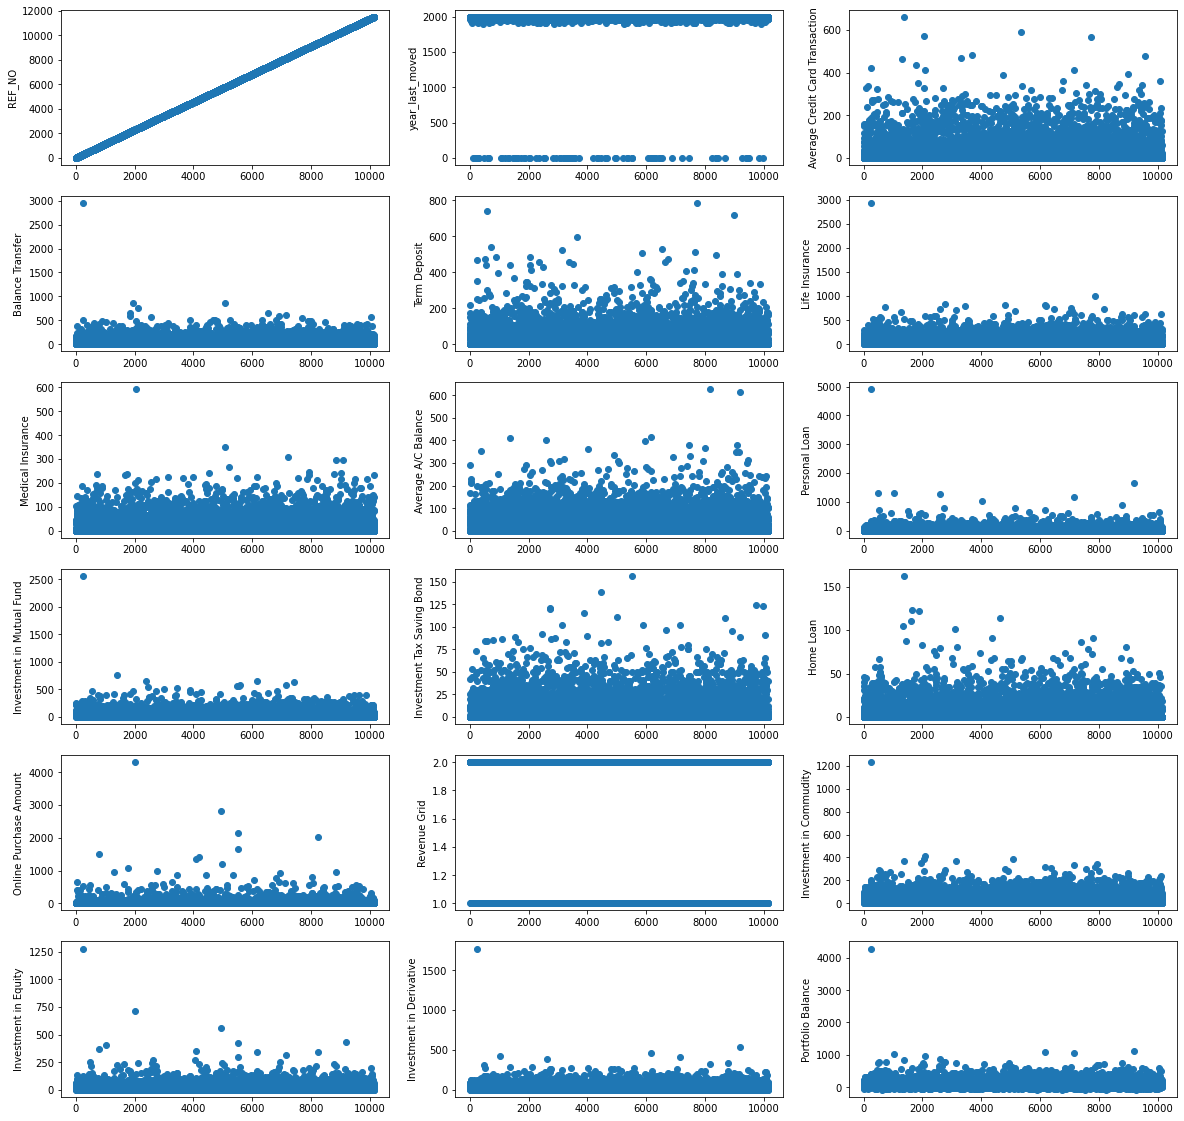

In [9]:
#### Visualizing numeric columns ######

numeric_cols = data.select_dtypes(include = np.number) ### selects numeric columns

column_names = list(numeric_cols.columns)

col_index = 0

plot_rows = 6
plot_cols = 3

fig, ax = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

for row_count in range(plot_rows):
    for col_count in range(plot_cols):
        ax[row_count][col_count].scatter(y = numeric_cols[column_names[col_index]],x=numeric_cols.index)
        ax[row_count][col_count].set_ylabel(column_names[col_index])
        col_index = col_index + 1
        
###### Insights #####
#####################

## Ref Number column just contains the index so can be removed.
## year_last_moved column seem to have many values close to 0 or 0, these seem to be noise.
## Average_credit_card_transaction,Balance Transfer seems to be highly right skewed.
## A single customer with very high value of balance transfer/life insurance etc stands out, this row could be considered outlier and removed, #row number 250
## Capping could be done to limit the impact of outliers.
## Scaling could be done since the scale is different for most of the variables.

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Investment Tax Saving Bond', ylabel='Density'>

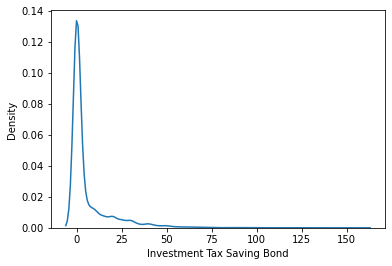

In [10]:
sns.distplot((data['Investment Tax Saving Bond']),hist = False)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Portfolio Balance', ylabel='Density'>

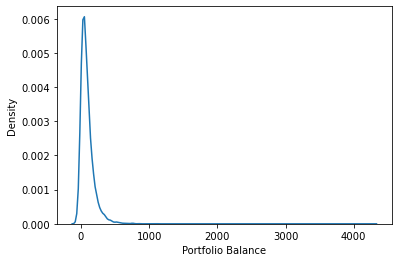

In [11]:
sns.distplot(data['Portfolio Balance'],hist = False)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Investment in Equity', ylabel='Density'>

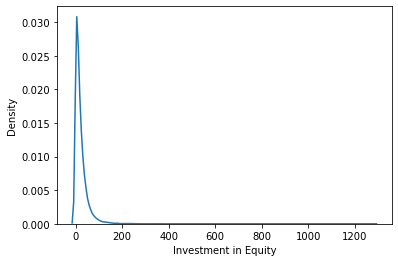

In [12]:
sns.distplot(data['Investment in Equity'],hist = False)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Online Purchase Amount', ylabel='Density'>

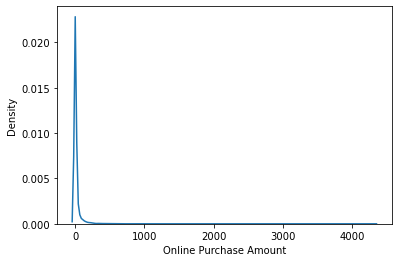

In [13]:
sns.distplot(data['Online Purchase Amount'],hist = False)

In [14]:
data.groupby(['Revenue Grid']).agg({'Online Purchase Amount': 'mean'})

,Online Purchase Amount
Revenue Grid,
1,118.808066
2,7.230388


<AxesSubplot:xlabel='Revenue Grid', ylabel='Online Purchase Amount'>

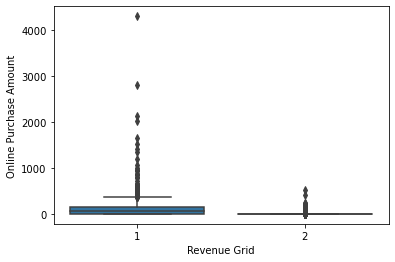

In [15]:
sns.boxplot(x='Revenue Grid', y = 'Online Purchase Amount', data = data)

In [16]:
np.sum(data['year_last_moved']==0) #### This computes the number of 0's in the year last moved columns

84

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Revenue Grid', ylabel='year_last_moved'>

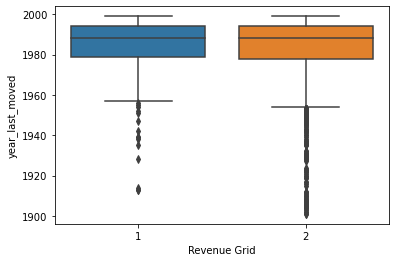

In [17]:
sns.boxplot(data.loc[data['year_last_moved']>0,'Revenue Grid'], data.loc[data['year_last_moved']>0,'year_last_moved'])

In [18]:
##### Correlation betwwen feature and the target columns

data[column_names].corr()

,REF_NO,year_last_moved,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
REF_NO,1.000000,0.028739,-0.001217,-0.010711,-0.002313,0.008301,0.020776,-0.005197,-0.010802,-0.006030,0.000775,-0.014010,0.003267,-0.010578,0.002082,-0.007154,-0.000234,-0.000721
year_last_moved,0.028739,1.000000,0.014296,0.013535,0.004404,0.010689,0.015484,0.003031,0.019718,0.002569,0.013158,0.003282,-0.005826,-0.018655,0.016802,0.008586,0.015582,0.017298
Average Credit Card Transaction,-0.001217,0.014296,1.000000,0.123855,0.323462,0.145041,0.405090,0.172240,0.087289,0.150667,0.133126,0.087695,0.132518,-0.265197,0.497025,0.205289,0.228141,0.335674
Balance Transfer,-0.010711,0.013535,0.123855,1.000000,0.229457,0.564538,0.162085,0.358938,0.351499,0.454602,0.166496,0.153097,0.112012,-0.074756,0.739791,0.463556,0.581039,0.639400
Term Deposit,-0.002313,0.004404,0.323462,0.229457,1.000000,0.274691,0.506367,0.274027,0.146755,0.208948,0.176975,0.170584,0.099455,-0.011817,0.620256,0.266908,0.354304,0.454740
Life Insurance,0.008301,0.010689,0.145041,0.564538,0.274691,1.000000,0.238435,0.514339,0.380563,0.544439,0.263675,0.279959,0.128785,-0.216090,0.803326,0.564287,0.839266,0.787311
Medical Insurance,0.020776,0.015484,0.405090,0.162085,0.506367,0.238435,1.000000,0.264615,0.105134,0.209651,0.201057,0.136310,0.149651,-0.092966,0.548282,0.269922,0.392548,0.441631
Average A/C Balance,-0.005197,0.003031,0.172240,0.358938,0.274027,0.514339,0.264615,1.000000,0.219801,0.448270,0.307552,0.367590,0.162821,-0.112118,0.517832,0.600278,0.657742,0.616051
Personal Loan,-0.010802,0.019718,0.087289,0.351499,0.146755,0.380563,0.105134,0.219801,1.000000,0.379615,0.233020,0.128062,0.073292,0.028982,0.377170,0.676053,0.687417,0.598919
Investment in Mutual Fund,-0.006030,0.002569,0.150667,0.454602,0.208948,0.544439,0.209651,0.448270,0.379615,1.000000,0.271580,0.261562,0.115087,-0.114689,0.536715,0.693435,0.761125,0.695337


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           10155 non-null  int64  
 1   children                         10155 non-null  object 
 2   age_band                         10155 non-null  object 
 3   status                           10155 non-null  object 
 4   occupation                       10155 non-null  object 
 5   occupation_partner               10155 non-null  object 
 6   home_status                      10155 non-null  object 
 7   family_income                    10155 non-null  object 
 8   self_employed                    10155 non-null  object 
 9   self_employed_partner            10155 non-null  object 
 10  year_last_moved                  10155 non-null  int64  
 11  TVarea                           10155 non-null  object 
 12  post_code         

In [20]:
##### Describing categorical columns #####

cat_data = data.select_dtypes(include = np.object) ##subsets the object columns

column_names = list(cat_data.columns) ### column names of the object columns

for column in column_names:
    print('Column ', column)
    print('Number of unique elements ', cat_data[column].nunique())
    print('***************\n')
    
##### Insights ######

## post_code and post area has too many unique values and doesn't seems like good feature variable. Just removing it or now.

Column  children
Number of unique elements  5
***************

Column  age_band
Number of unique elements  13
***************

Column  status
Number of unique elements  5
***************

Column  occupation
Number of unique elements  9
***************

Column  occupation_partner
Number of unique elements  9
***************

Column  home_status
Number of unique elements  5
***************

Column  family_income
Number of unique elements  13
***************

Column  self_employed
Number of unique elements  2
***************

Column  self_employed_partner
Number of unique elements  2
***************

Column  TVarea
Number of unique elements  14
***************

Column  post_code
Number of unique elements  10040
***************

Column  post_area
Number of unique elements  2039
***************

Column  gender
Number of unique elements  3
***************

Column  region
Number of unique elements  13
***************



C:\Users\user\AppData\Local\Temp/ipykernel_8660/3344279863.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_data = data.select_dtypes(include = np.object) ##subsets the object columns


# Data Preprocessing

In [21]:
print('The shape of the data before preprocessing ', data.shape)

The shape of the data before preprocessing  (10155, 32)


In [22]:
data = data.loc[data['Life Insurance']<2500,:] ### Dropping the customer with unusually high feature values

In [23]:
remove_cols = []

In [24]:
#### Preprocess -Removing the Ref_no AND YEAR_LAST_Moved column
data.drop(['REF_NO'],axis=1,inplace=True)
data.drop(['year_last_moved'],axis=1,inplace=True)
remove_cols.append('REF_NO')
remove_cols.append('year_last_moved')

In [25]:
data.shape

(10154, 30)

In [26]:
### Removing the post_code AND post_area column
data.drop(['post_code','post_area'],axis=1,inplace=True)

remove_cols.extend(['post_code','post_area'])

In [27]:
print('The shape of the data after first preprocessing block ', data.shape)

data.reset_index(drop=True,inplace=True) ### resetting index

The shape of the data after first preprocessing block  (10154, 28)


In [28]:
###### Capping the numeric columns to 99.95th percentile #####

numeric_cols = data.select_dtypes(include = np.number) ### Data frame with only numeric columns
column_names = list(numeric_cols.columns) ### contains the numeric column names
column_names.remove('Revenue Grid')  ### removing revenue grid

for column in column_names:  ### iterating over all numeric columns
    percentile_9995_val = np.quantile(data[column],0.9995)  ### finding the 99.95th percentile value
    print (column, percentile_9995_val)
    data.loc[data[column]>percentile_9995_val,column] = percentile_9995_val  ## replace all the values greater than 95th percentile with the 95th percentile value



Average Credit Card Transaction 477.0595900000078
Balance Transfer 601.467500000004
Term Deposit 531.109205000007
Life Insurance 794.1689650000167
Medical Insurance 264.1921900000169
Average A/C Balance 396.7357850000136
Personal Loan 1023.025560000106
Investment in Mutual Fund 575.7975700000084
Investment Tax Saving Bond 119.57088500000307
Home Loan 104.29842500000278
Online Purchase Amount 1505.0639500000832
Investment in Commudity 348.4696900000052
Investment in Equity 366.65306000001567
Investment in Derivative 329.4782800000082
Portfolio Balance 860.9368800000143


In [29]:
column_names

['Average Credit Card Transaction',
 'Balance Transfer',
 'Term Deposit',
 'Life Insurance',
 'Medical Insurance',
 'Average A/C Balance',
 'Personal Loan',
 'Investment in Mutual Fund',
 'Investment Tax Saving Bond',
 'Home Loan',
 'Online Purchase Amount',
 'Investment in Commudity',
 'Investment in Equity',
 'Investment in Derivative',
 'Portfolio Balance']

In [30]:
data[column_names].describe()

,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
count,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000
mean,23.395952,46.056182,27.486741,65.932152,19.090556,32.020525,25.367067,42.051908,6.105100,4.471583,18.630199,36.429104,21.505433,31.761640,89.955236
std,50.380326,72.306635,53.105956,90.975454,31.882423,44.960507,66.171623,58.405355,12.768501,9.853086,73.769768,40.426748,28.232455,34.507729,98.053353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-78.430000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.215000,4.670000,8.740000,26.602500
50%,0.000000,17.960000,0.000000,31.980000,0.510000,14.990000,0.000000,23.480000,0.000000,0.000000,0.000000,23.940000,12.980000,21.335000,66.175000
75%,23.980000,65.240000,34.987500,94.380000,27.470000,46.477500,21.480000,59.480000,5.970000,4.490000,7.980000,50.787500,28.300000,42.980000,125.917500
max,477.059590,601.467500,531.109205,794.168965,264.192190,396.735785,1023.025560,575.797570,119.570885,104.298425,1505.063950,348.469690,366.653060,329.478280,860.936880


In [31]:
####### Scaling the columns ######

scaler = StandardScaler()  ### instance of this object

scaler.fit(data[column_names]) ### it will compute mean and standard deviation of every column

data[column_names] = scaler.transform(data[column_names]) #### apply the formula (x-mean)/s.d

with open('scaler.pickle','wb') as f:
  pickle.dump(scaler,f)

In [32]:
data[column_names].describe()

,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
count,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04,1.015400e+04
mean,-1.910909e-16,-3.021815e-16,-4.083574e-16,3.844341e-16,-7.893146e-17,-4.284757e-16,-4.832761e-17,2.331435e-16,-1.734764e-16,-2.830938e-16,3.949744e-16,-1.464042e-16,-2.819840e-17,1.196819e-16,7.185726e-17
std,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00
min,-4.644095e-01,-6.369879e-01,-5.176085e-01,-7.247603e-01,-5.988094e-01,-7.122273e-01,-3.833715e-01,-7.200364e-01,-4.781611e-01,-4.538480e-01,-2.525576e-01,-9.011583e-01,-7.617649e-01,-9.204664e-01,-1.717366e+00
25%,-4.644095e-01,-6.369879e-01,-5.176085e-01,-7.247603e-01,-5.988094e-01,-7.122273e-01,-3.833715e-01,-7.200364e-01,-4.781611e-01,-4.538480e-01,-2.525576e-01,-6.979412e-01,-5.963443e-01,-6.671773e-01,-6.461366e-01
50%,-4.644095e-01,-3.885890e-01,-5.176085e-01,-3.732196e-01,-5.828124e-01,-3.788072e-01,-3.833715e-01,-3.179986e-01,-4.781611e-01,-4.538480e-01,-2.525576e-01,-3.089469e-01,-3.019877e-01,-3.021686e-01,-2.425354e-01
75%,1.159335e-02,2.653251e-01,1.412483e-01,3.127135e-01,2.628363e-01,3.215641e-01,-5.874510e-02,2.984136e-01,-1.058125e-02,1.869285e-03,-1.443779e-01,3.551882e-01,2.406770e-01,3.251130e-01,3.667803e-01
max,9.005221e+00,7.681711e+00,9.483819e+00,8.005156e+00,7.688051e+00,8.112302e+00,1.507758e+01,9.139093e+00,8.886820e+00,1.013203e+01,2.015063e+01,7.719047e+00,1.222581e+01,8.627960e+00,7.863266e+00


In [33]:
data.dtypes

children                            object
age_band                            object
status                              object
occupation                          object
occupation_partner                  object
home_status                         object
family_income                       object
self_employed                       object
self_employed_partner               object
TVarea                              object
Average Credit Card Transaction    float64
Balance Transfer                   float64
Term Deposit                       float64
Life Insurance                     float64
Medical Insurance                  float64
Average A/C Balance                float64
Personal Loan                      float64
Investment in Mutual Fund          float64
Investment Tax Saving Bond         float64
Home Loan                          float64
Online Purchase Amount             float64
Revenue Grid                         int64
gender                              object
region     

In [34]:
##### Preprocessing categorical columns ######

### Analzing the children column ####

print(data['children'].value_counts())

children_pickle = {}

#### Insight ###
################

#Since the occurances of 4+ children is quite low when compared to rest, we can replace them with 3
#Create one hot encoded vectors for the same

data.loc[data['children']== '4+','children'] = '3'

children_data = pd.get_dummies(data['children'],prefix ='chidren')

data.drop(['children'],axis=1,inplace=True)

data = pd.concat([data,children_data],axis=1)

Zero    6208
1       1847
2       1607
3        473
4+        19
Name: children, dtype: int64


In [35]:
'''
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoder.fit(data['children']) #### identify how many unique values are there in the columns and what are they [0,1,2,3]

encoder.transform(data['children']) #### for every unique value it will create a one hot column

##### store the encoder object in a pickle
'''

"\nfrom sklearn.preprocessing import OneHotEncoder\n\nencoder = OneHotEncoder()\n\nencoder.fit(data['children']) #### identify how many unique values are there in the columns and what are they [0,1,2,3]\n\nencoder.transform(data['children']) #### for every unique value it will create a one hot column\n\n##### store the encoder object in a pickle\n"

In [36]:
'''
from sklearn.preprocessing import OneHotEncoder

age_band_encoder = OneHotEncoder()

age_band_encoder.fit(data[['age_band']]) #### try to identify what all are the unique values in the age band column

dummy_cols = age_band_encoder.transform(data[['age_band']]) ##### create dummies for each of the unique values identified 

dummy_cols = pd.DataFrame(dummy_cols.toarray())

dummy_cols.columns = age_band_encoder.categories_

data.drop(['age_band'],axis=1,inplace=True)

data = pd.concat([data,dummy_cols],axis=1)

with open('age_band_encoder.pickle','wb') as f:
  pickle.dump(age_band_encoder,f)
'''

"\nfrom sklearn.preprocessing import OneHotEncoder\n\nage_band_encoder = OneHotEncoder()\n\nage_band_encoder.fit(data[['age_band']]) #### try to identify what all are the unique values in the age band column\n\ndummy_cols = age_band_encoder.transform(data[['age_band']]) ##### create dummies for each of the unique values identified \n\ndummy_cols = pd.DataFrame(dummy_cols.toarray())\n\ndummy_cols.columns = age_band_encoder.categories_\n\ndata.drop(['age_band'],axis=1,inplace=True)\n\ndata = pd.concat([data,dummy_cols],axis=1)\n\nwith open('age_band_encoder.pickle','wb') as f:\n  pickle.dump(age_band_encoder,f)\n"

In [37]:
#### Analyzing age_band column ###

print(data['age_band'].value_counts())

#### Insight ####
#################

#Adding unknown to the most prominant class of 45-50 (In 2nd iteration)
#The mean age of the band could be taken and this column could be converted into a numeric column, however it so can
#happen that the band actually matters rather than the actual age, hence created dummies 

#data.loc[data['age_band']=='Unknown','age_band'] ='45-50'

age_band_dummies = pd.get_dummies(data['age_band'],prefix = 'age_band')

data.drop(['age_band'],axis=1,inplace=True)

data = pd.concat([data,age_band_dummies],axis=1)

45-50      1359
36-40      1134
41-45      1111
31-35      1061
51-55      1052
55-60      1047
26-30       927
61-65       881
65-70       598
22-25       456
71+         410
18-21        63
Unknown      55
Name: age_band, dtype: int64


In [38]:
data.head()

,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,TVarea,Average Credit Card Transaction,Balance Transfer,...,age_band_31-35,age_band_36-40,age_band_41-45,age_band_45-50,age_band_51-55,age_band_55-60,age_band_61-65,age_band_65-70,age_band_71+,age_band_Unknown
0,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,HTV,2.482124,1.340106,...,0,0,0,0,1,0,0,0,0,0
1,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,Granada,-0.464410,0.400036,...,0,0,0,0,0,1,0,0,0,0
2,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,Tyne Tees,-0.464410,1.664989,...,0,0,0,0,0,0,0,0,0,0
3,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,Central,-0.464410,-0.636988,...,0,0,0,0,0,0,0,0,0,0
4,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,Scottish TV,0.993573,0.164638,...,0,0,0,1,0,0,0,0,0,0


In [39]:
#### Analyzing status column ###

print(data['status'].value_counts())

#### Insight ####
#################

#Lets add unknown to the most prominant class of Partner (In 2nd iteration)
#Create dummeis for the rest 

#data.loc[data['status']=='Unknown','status'] ='Partner'

status_dummies = pd.get_dummies(data['status'],prefix = 'status')

data.drop(['status'],axis=1,inplace=True)

data = pd.concat([data,status_dummies],axis=1)

Partner                 7708
Single/Never Married    1101
Divorced/Separated       679
Widowed                  618
Unknown                   48
Name: status, dtype: int64


In [40]:
#### Analyzing occupation column ###

print(data['occupation'].value_counts())

occupation_dummies = pd.get_dummies(data['occupation'], drop_first=True, prefix = 'occupation')

data.drop(['occupation'],axis=1,inplace=True)

data = pd.concat([data,occupation_dummies],axis=1)

Professional         2448
Retired              2206
Secretarial/Admin    1797
Housewife            1255
Business Manager      732
Unknown               567
Manual Worker         556
Other                 537
Student                56
Name: occupation, dtype: int64


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10154 entries, 0 to 10153
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   occupation_partner               10154 non-null  object 
 1   home_status                      10154 non-null  object 
 2   family_income                    10154 non-null  object 
 3   self_employed                    10154 non-null  object 
 4   self_employed_partner            10154 non-null  object 
 5   TVarea                           10154 non-null  object 
 6   Average Credit Card Transaction  10154 non-null  float64
 7   Balance Transfer                 10154 non-null  float64
 8   Term Deposit                     10154 non-null  float64
 9   Life Insurance                   10154 non-null  float64
 10  Medical Insurance                10154 non-null  float64
 11  Average A/C Balance              10154 non-null  float64
 12  Personal Loan     

In [42]:
#### Analyzing occupation_partner column ###

print(data['occupation_partner'].value_counts())

occupation_partner_dummies = pd.get_dummies(data['occupation_partner'],drop_first=True,prefix = 'occupation_partner')

data.drop(['occupation_partner'],axis=1,inplace=True)

data = pd.concat([data,occupation_partner_dummies],axis=1)

Unknown              2394
Professional         2050
Retired              1936
Manual Worker        1508
Business Manager      737
Secretarial/Admin     662
Housewife             527
Other                 324
Student                16
Name: occupation_partner, dtype: int64


In [43]:
#### Analyzing home_status column ###

print(data['home_status'].value_counts())

#### Insight ####
#################

#Apart form own home the other types seem to be some/kind of rented property and the occurances of those are quite few compared to own house
#combine all others into a category called rent
#Create dummies for rest

#data.loc[~(data['home_status'] == 'Own Home'),'home_status'] ='Rented Home' (In 2nd iteration)

home_status_dummies = pd.get_dummies(data['home_status'],prefix = 'home_status')

data.drop(['home_status'],axis=1,inplace=True)

data = pd.concat([data,home_status_dummies],axis=1)

Own Home                9412
Rent from Council/HA     322
Rent Privately           261
Live in Parental Hom     109
Unclassified              50
Name: home_status, dtype: int64


In [44]:
#### Analyzing family_income column ###

print(data['family_income'].value_counts())

#### Insight ####
#################

#The family income could be converted into numeric field by taking the mean of the range. Will explore it in the next set of experiments
#In the current experiment, created dummies

income_dummies = pd.get_dummies(data['family_income'], prefix = 'income')

data.drop(['family_income'],axis=1,inplace=True)

data = pd.concat([data,income_dummies],axis=1)

>=35,000             2516
<27,500, >=25,000    1227
<30,000, >=27,500     994
<25,000, >=22,500     833
<20,000, >=17,500     683
<12,500, >=10,000     677
<17,500, >=15,000     634
<15,000, >=12,500     629
<22,500, >=20,000     590
<10,000, >= 8,000     563
< 8,000, >= 4,000     402
< 4,000               278
Unknown               128
Name: family_income, dtype: int64


In [45]:
#### Analyzing the self employed, self employed partner and gender column ####

cols = ['self_employed','self_employed_partner','gender']

for column in cols:
    dummies = pd.get_dummies(data[column],drop_first=True,prefix = column)
    data.drop(column,axis=1,inplace=True)
    data = pd.concat([data,dummies],axis=1)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10154 entries, 0 to 10153
Data columns (total 78 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   TVarea                                10154 non-null  object 
 1   Average Credit Card Transaction       10154 non-null  float64
 2   Balance Transfer                      10154 non-null  float64
 3   Term Deposit                          10154 non-null  float64
 4   Life Insurance                        10154 non-null  float64
 5   Medical Insurance                     10154 non-null  float64
 6   Average A/C Balance                   10154 non-null  float64
 7   Personal Loan                         10154 non-null  float64
 8   Investment in Mutual Fund             10154 non-null  float64
 9   Investment Tax Saving Bond            10154 non-null  float64
 10  Home Loan                             10154 non-null  float64
 11  Online Purchase

In [47]:
#### Analyzing the TVarea column #####

print(data['TVarea'].value_counts())

### Insight ####
################

#Intuitively, TVArea doesn't make sense in predicting if the user is a high transaction user or not.
#In the current set , removing this column. 
data.drop(['TVarea'],axis=1,inplace=True)

Central          1618
Carlton          1541
Meridian         1226
Yorkshire        1042
Granada          1039
HTV               845
Anglia            751
Tyne Tees         535
Scottish TV       520
TV South West     363
Grampian          227
Unknown           189
Ulster            159
Border             99
Name: TVarea, dtype: int64


In [48]:
### Analyzing the region column ####

print(data['region'].value_counts())

region_dummies = pd.get_dummies(data['region'],drop_first=True,prefix = 'region')

data.drop(['region'],axis=1,inplace=True)

data = pd.concat([data,region_dummies],axis=1)

South East          2100
North West          1896
Unknown             1080
South West           971
West Midlands        820
Scotland             787
East Midlands        771
North                570
Wales                556
East Anglia          423
Northern Ireland     159
Isle of Man           16
Channel Islands        5
Name: region, dtype: int64


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10154 entries, 0 to 10153
Data columns (total 88 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Average Credit Card Transaction       10154 non-null  float64
 1   Balance Transfer                      10154 non-null  float64
 2   Term Deposit                          10154 non-null  float64
 3   Life Insurance                        10154 non-null  float64
 4   Medical Insurance                     10154 non-null  float64
 5   Average A/C Balance                   10154 non-null  float64
 6   Personal Loan                         10154 non-null  float64
 7   Investment in Mutual Fund             10154 non-null  float64
 8   Investment Tax Saving Bond            10154 non-null  float64
 9   Home Loan                             10154 non-null  float64
 10  Online Purchase Amount                10154 non-null  float64
 11  Revenue Grid   

In [50]:
print('The shape of data after all preprocessing ',data.shape)

The shape of data after all preprocessing  (10154, 88)



# Modelling Data Prep

In [51]:
#### Since its a classification problem, converting target column into 0/1s #####

data.loc[data['Revenue Grid']==2,'Revenue Grid'] = 0 ## this replaces all the 2's with 0 ### making targets as 1 and 0 

data.reset_index(drop=True,inplace=True)

features_df = data.drop(['Revenue Grid'],axis=1)

target_df = data['Revenue Grid']

In [52]:
data['Revenue Grid'].value_counts()

0    9068
1    1086
Name: Revenue Grid, dtype: int64

In [53]:
round((9068/(9068+1086)*100),2), round(((1086/(9068+1086))*100),2) ### Imbalance data between Revenue Grid

(89.3, 10.7)

In [54]:
features_df.shape, target_df.shape

((10154, 87), (10154,))

In [55]:
features_df.head()

,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,...,region_Isle of Man,region_North,region_North West,region_Northern Ireland,region_Scotland,region_South East,region_South West,region_Unknown,region_Wales,region_West Midlands
0,2.482124,1.340106,-0.517609,0.176186,-0.598809,-0.045165,-0.383372,0.340706,1.087487,-0.453848,...,0,0,0,0,0,0,0,0,1,0
1,-0.464410,0.400036,-0.517609,-0.439065,-0.598809,-0.712227,-0.383372,-0.720036,-0.478161,-0.453848,...,0,0,1,0,0,0,0,0,0,0
2,-0.464410,1.664989,-0.122341,2.478129,-0.238719,3.000992,-0.383372,-0.446247,-0.478161,-0.099627,...,0,1,0,0,0,0,0,0,0,0
3,-0.464410,-0.636988,-0.517609,-0.499524,-0.598809,0.165475,-0.383372,0.058013,-0.478161,-0.453848,...,0,0,0,0,0,0,0,0,0,1
4,0.993573,0.164638,-0.517609,1.225532,0.717027,0.165697,-0.217582,2.924330,-0.478161,4.205835,...,0,0,0,0,1,0,0,0,0,0


In [56]:
##### Creating a test set to validate the model ######

#split_size = 0.2

split_ins = StratifiedShuffleSplit(n_splits=5, random_state=2364)

splits = split_ins.split(features_df,target_df) ### return the rows that should be in training set and rows that goes in validation set

for train_index, val_index in splits:
    features_train = features_df.iloc[train_index,:]   ## features for the training set
    target_train = target_df[train_index]    ##### target values for the training set
    features_val = features_df.iloc[val_index,:]   #### features for the validation set
    target_val = target_df[val_index]            #### targets for the validation set

In [57]:
features_train.shape,features_val.shape,target_train.shape,target_val.shape

((9138, 87), (1016, 87), (9138,), (1016,))

In [73]:
target_val.value_counts()

0    907
1    109
Name: Revenue Grid, dtype: int64

In [59]:
features_train.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
features_val.reset_index(drop=True, inplace=True)
target_val.reset_index(drop=True, inplace=True)

# Modelling

In [60]:
### logistic regression model ####
LR_model = LogisticRegression(class_weight = 'balanced',max_iter=200, random_state=2000) 

In [61]:
LR_model

LogisticRegression(class_weight='balanced', max_iter=200, random_state=2000)

In [62]:
### Fitting the model ####

LR_model.fit(features_train,target_train)

LogisticRegression(class_weight='balanced', max_iter=200, random_state=2000)

In [65]:
dict(zip(list(features_df.columns), list(LR_model.coef_[0])))

{'Average Credit Card Transaction': 1.1276876031820238,
 'Balance Transfer': -0.47447260291927246,
 'Term Deposit': -1.062557879967702,
 'Life Insurance': 1.2659088570520292,
 'Medical Insurance': -0.36345584663571084,
 'Average A/C Balance': -0.1633626285971397,
 'Personal Loan': -2.1536803728318765,
 'Investment in Mutual Fund': 0.0037125009541886913,
 'Investment Tax Saving Bond': 1.146522926945977,
 'Home Loan': -0.7718371507721002,
 'Online Purchase Amount': 3.9611197370364275,
 'Investment in Commudity': 0.3142042867596878,
 'Investment in Equity': 0.26264421081087763,
 'Investment in Derivative': -0.05540467092359169,
 'Portfolio Balance': -0.09950639159810473,
 'chidren_1': 0.2637558705444524,
 'chidren_2': -0.08340418126704395,
 'chidren_3': -0.08116021018272647,
 'chidren_Zero': -0.08974500441377017,
 'age_band_18-21': 0.44654449333021456,
 'age_band_22-25': -0.45216601943563284,
 'age_band_26-30': 0.12977810661024558,
 'age_band_31-35': -0.16479362307865994,
 'age_band_36-40

In [66]:
prediction_train = pd.DataFrame(LR_model.predict_proba(features_train)) #### give me the predicted probabilities on features_train

In [67]:
prediction_train

,0,1
0,0.479966,5.200339e-01
1,0.999999,7.826262e-07
2,0.961750,3.825043e-02
3,0.961566,3.843357e-02
4,0.788871,2.111289e-01
...,...,...
9133,0.928133,7.186694e-02
9134,0.935667,6.433260e-02
9135,0.785294,2.147061e-01
9136,0.954509,4.549135e-02


In [68]:
predictions = LR_model.predict(features_train) ### applies a threshold of 0.5

In [69]:
predictions

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
#### Plotting the roc curve for the model fit ####

plot_roc_curve(LR_model,X =features_train, y= target_train)

In [70]:
### Getting confusion matrix, F-score on the train data #####

print(confusion_matrix(y_true = target_train, y_pred = LR_model.predict(features_train))) ### confusion matrix for pred on train set

print ('The F1-SCORE on the train set prediction ',f1_score(y_true=target_train, y_pred = LR_model.predict(features_train)))

[[7446  715]
 [  97  880]]
The F1-SCORE on the train set prediction  0.6842923794712286


In [ ]:
LR_model.predict(features_train)

In [74]:
##### Evaluating the performace on the test set #####

predicted_val = LR_model.predict(features_val)

print (confusion_matrix(y_true = target_val, y_pred = predicted_val))

print ('The F1-SCORE on the test set prediction ',f1_score(y_true=target_val,y_pred = predicted_val))

[[830  77]
 [  9 100]]
The F1-SCORE on the test set prediction  0.6993006993006994


In [75]:
##### fitting a decision tree #####

clf = DecisionTreeClassifier(class_weight ='balanced',
                             max_depth = 5, 
                             criterion = 'gini',
                             min_samples_split=25)

clf.fit(features_train,target_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=25)

In [76]:
clf.predict(features_train) 

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [77]:
clf.predict(features_val)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [78]:
clf.classes_ ### give us the classes that were present on the training set and that were used by the model to train on

dict(zip(list(features_train.columns),list(clf.feature_importances_)))

{'Average Credit Card Transaction': 0.062259444091556836,
 'Balance Transfer': 0.0,
 'Term Deposit': 0.023580583468520325,
 'Life Insurance': 0.09046156701881382,
 'Medical Insurance': 0.0032710591167206407,
 'Average A/C Balance': 1.2468461371876041e-17,
 'Personal Loan': 0.04058514721067547,
 'Investment in Mutual Fund': 0.0,
 'Investment Tax Saving Bond': 0.18826144296192918,
 'Home Loan': 0.0032277915088953493,
 'Online Purchase Amount': 0.3972091550975649,
 'Investment in Commudity': 0.18948622991741085,
 'Investment in Equity': 0.0,
 'Investment in Derivative': 0.0,
 'Portfolio Balance': 0.0,
 'chidren_1': 0.0,
 'chidren_2': 0.0,
 'chidren_3': 0.0,
 'chidren_Zero': 0.0,
 'age_band_18-21': 0.0,
 'age_band_22-25': 0.0,
 'age_band_26-30': 0.0,
 'age_band_31-35': 0.0,
 'age_band_36-40': 0.0,
 'age_band_41-45': 0.0,
 'age_band_45-50': 0.0,
 'age_band_51-55': 0.0,
 'age_band_55-60': 0.0016575796079110502,
 'age_band_61-65': 0.0,
 'age_band_65-70': 0.0,
 'age_band_71+': 0.0,
 'age_band_

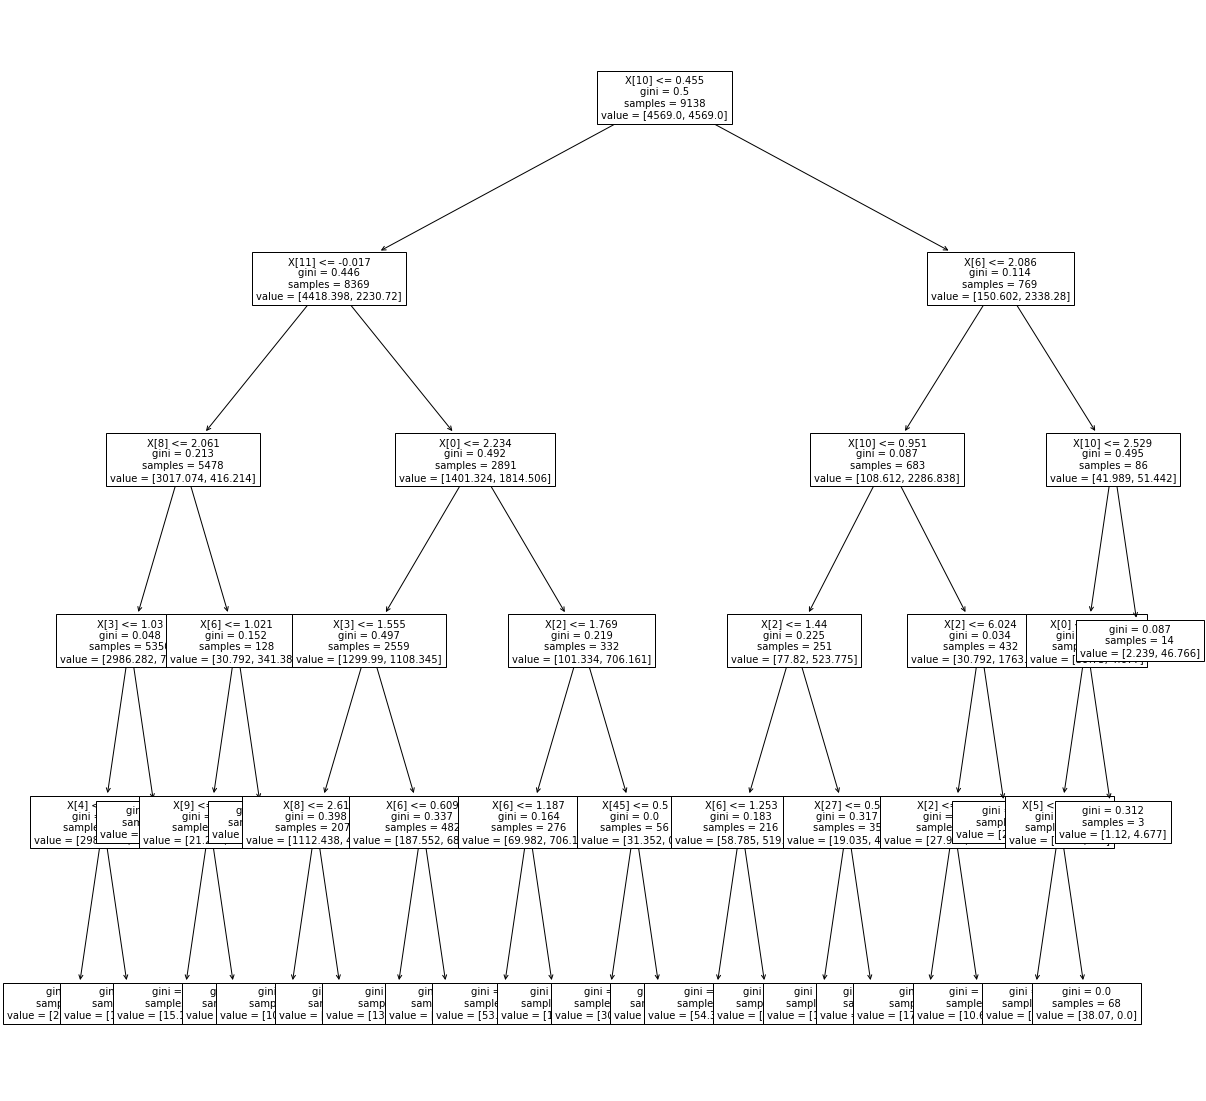

In [80]:
from sklearn.tree import plot_tree
plot_rows =1
plot_cols = 1

fig, ax1 = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

plot_tree(clf,ax=ax1,fontsize=10)
plt.show()

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


[[7599  562]
 [  76  901]]
The F1-SCORE on the train set prediction  0.7385245901639345


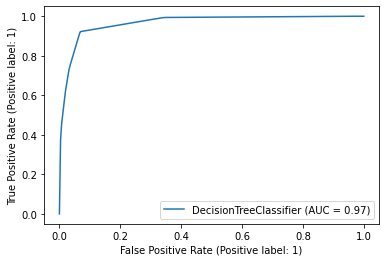

In [81]:
### Evaluating on the train and the test set ####

predicted_train = clf.predict(features_train)

plot_roc_curve(clf,X =features_train, y= target_train)

#print ('The score for the DT model ', roc_auc_score(Y_train,predicted_train))

print(confusion_matrix(y_true = target_train, y_pred = predicted_train))

print ('The F1-SCORE on the train set prediction ',f1_score(y_true=target_train,y_pred = predicted_train))

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


[[848  59]
 [ 11  98]]
The F1-SCORE on the val set prediction  0.7368421052631579


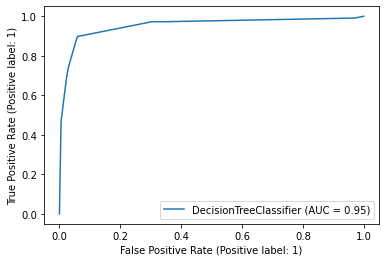

In [83]:
plot_roc_curve(clf,X =features_val, y= target_val)

predicted_test = clf.predict(features_val)

print (confusion_matrix(y_true = target_val, y_pred = predicted_test))

print ('The F1-SCORE on the val set prediction ',f1_score(y_true=target_val,y_pred = predicted_test))

In [94]:
##### Creating a decision tree classifier ####

clf = DecisionTreeClassifier()
#clf = LogisticRegression()  
#clf = SVC()

params={'class_weight':[None,'balanced', {0:0.4,1:0.6}, {0:0.45, 1:0.55}, {0:0.35, 1:0.65}],
        'max_depth' : [5, 8, 10, 15, 20],
        'criterion' :['gini'],
        'min_samples_split' : [2,5,10,20]}           ### parameter distribution 

grid_search = GridSearchCV(estimator = clf, param_grid = params, cv = 3, scoring = 'f1', return_train_score=True) #### cv- 5 (5 fold cross validation)

grid_search.fit(features_train,target_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced', {0: 0.4, 1: 0.6},
                                          {0: 0.45, 1: 0.55},
                                          {0: 0.35, 1: 0.65}],
                         'criterion': ['gini'], 'max_depth': [5, 8, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             return_train_score=True, scoring='f1')

In [102]:
list(grid_search.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_class_weight',
 'param_criterion',
 'param_max_depth',
 'param_min_samples_split',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'mean_train_score',
 'std_train_score']

In [126]:
grid_search.cv_results_['params'][2]

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 10}

In [124]:
grid_search.cv_results_['mean_train_score'][2]

0.8013339787434325

In [125]:
grid_search.cv_results_['mean_test_score'][2]

0.7413270457317892

In [137]:
list(grid_search.cv_results_['rank_test_score']).index(2)

46

In [116]:
df = pd.DataFrame(zip(grid_search.cv_results_['params'], 
                      grid_search.cv_results_['mean_train_score'], 
                      grid_search.cv_results_['mean_test_score']), columns = ['param_comb', 'Train_F1', 'Val_F1'])

df.to_excel('grid_search_results.xlsx', index=None)

In [138]:
clf = DecisionTreeClassifier(class_weight= None, criterion = 'entropy', max_depth = 7, min_samples_split = 10)

clf.fit(features_train,target_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10)

In [142]:
#### Fitting a decision tree classifier ######

clf = RandomForestClassifier() ### random forest function from  sklearn

params={'n_estimators':[100],
        'class_weight':['balanced'],    
        'criterion':['gini'], 
        'max_depth':[5,10,15],
        'min_samples_split':[10,20,50],
        'max_samples':[0.6,0.7,0.8],
        'max_features':['auto']}        #### parameter combinations

In [143]:
##### Fitting grid search cv to find the best combination of hyper parameters ####

grid_search = GridSearchCV(estimator = clf,param_grid = params,cv = 5,scoring = 'f1',return_train_score=True)

grid_search.fit(features_df,target_df)

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'], 'criterion': ['gini'],
                         'max_depth': [5, 10, 15], 'max_features': ['auto'],
                         'max_samples': [0.6, 0.7, 0.8],
                         'min_samples_split': [10, 20, 50],
                         'n_estimators': [100]},
             return_train_score=True, scoring='f1')

In [157]:
a = grid_search.cv_results_ ### parameter comb,train_score, val_score

print(a['params'][25])

print(a['mean_train_score'][25])

print(a['mean_test_score'][25])

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_samples': 0.8, 'min_samples_split': 20, 'n_estimators': 100}
0.9412585384667954
0.813894466584095


In [156]:
list(a['rank_test_score']).index(1)

25

In [145]:
combinations = grid_search.cv_results_['params']
len(combinations)

27

In [158]:
best_estimator = grid_search.best_estimator_

In [147]:
best_estimator

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='auto', max_samples=0.8,
                       min_samples_split=20)

In [159]:
print(best_estimator) #### best combination

print(grid_search.best_score_) #### best score

best_params = grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='auto', max_samples=0.8,
                       min_samples_split=20)
0.813894466584095


In [160]:
clf = best_estimator

clf.fit(features_train,target_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='auto', max_samples=0.8,
                       min_samples_split=20)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


The score for the DT model  0.9860562073631524
[[8042  119]
 [  13  964]]
The F1-SCORE on the train set prediction  0.9933024214322513


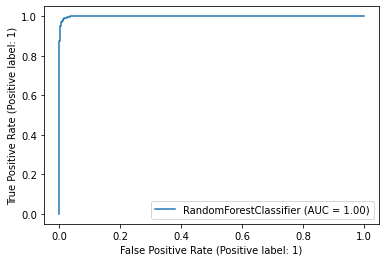

In [162]:
### Evaluating on the train and the test set ####

predicted_train = clf.predict(features_train)

plot_roc_curve(clf,X =features_train, y= target_train)

print ('The score for the DT model ', roc_auc_score(target_train,predicted_train))

print(confusion_matrix(y_true = target_train, y_pred = predicted_train))

print ('The F1-SCORE on the train set prediction ',f1_score(y_true=target_train,y_pred = predicted_train,sample_weight = target_train))

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


[[886  21]
 [ 17  92]]
The F1-SCORE on the test set prediction  0.9154228855721394


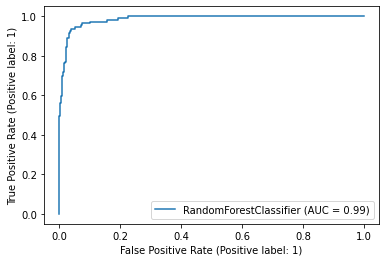

In [163]:
plot_roc_curve(clf,X =features_val, y= target_val)

predicted_test = clf.predict(features_val)

print (confusion_matrix(y_true = target_val, y_pred = predicted_test))

print ('The F1-SCORE on the test set prediction ',f1_score(y_true=target_val,y_pred = predicted_test,sample_weight = target_val))

In [164]:
### Calculating the feature importances ####

importances = clf.feature_importances_

columns = list(features_train.columns)

importances_dict = {columns[i]: importances[i] for i in range(len(columns))}

importances_dict = dict(sorted(importances_dict.items(), key=lambda importances_dict: importances_dict[1],reverse=True))

In [165]:
importances_dict

{'Online Purchase Amount': 0.2441064882311456,
 'Investment Tax Saving Bond': 0.09652478553021618,
 'Investment in Equity': 0.08949980334611117,
 'Average Credit Card Transaction': 0.08838868907857135,
 'Investment in Commudity': 0.08259131442830554,
 'Life Insurance': 0.0634213112034386,
 'Portfolio Balance': 0.04805154417987887,
 'Investment in Derivative': 0.04574401563768894,
 'Personal Loan': 0.03169574616689422,
 'Term Deposit': 0.027293990002514826,
 'Investment in Mutual Fund': 0.024794302975353125,
 'Average A/C Balance': 0.023884838305266068,
 'Medical Insurance': 0.02063557118875791,
 'Balance Transfer': 0.020587209318287697,
 'Home Loan': 0.01197335459920019,
 'occupation_Secretarial/Admin': 0.0019572485399487896,
 'income_>=35,000': 0.0018174064961770805,
 'income_<27,500, >=25,000': 0.001778896776700253,
 'gender_Male': 0.0017770982502040887,
 'region_Unknown': 0.001713807965042284,
 'region_North West': 0.0016714168550143068,
 'age_band_45-50': 0.0016234664531012423,
 'r